<a href="https://colab.research.google.com/github/KushalShah1/ImageProcessingFinal/blob/main/LicensePlateDetection/433imgLicenseDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import cv2
import os
import glob

In [ ]:
import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/433licenseplates'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/MyDrive/433licenseplates/annotations/Cars121.xml
/content/drive/MyDrive/433licenseplates/annotations/Cars128.xml
/content/drive/MyDrive/433licenseplates/annotations/Cars106.xml
/content/drive/MyDrive/433licenseplates/annotations/Cars132.xml
/content/drive/MyDrive/433licenseplates/annotations/Cars111.xml
/content/drive/MyDrive/433licenseplates/annotations/Cars118.xml
/content/drive/MyDrive/433licenseplates/annotations/Cars12.xml
/content/drive/MyDrive/433licenseplates/annotations/Cars135.xml
/content/drive/MyDrive/433licenseplates/annotations/Cars130.xml
/content/drive/MyDrive/433licenseplates/annotations/Cars11.xml
/content/drive/MyDrive/433licenseplates/annotations/Cars116.xml
/content/drive/MyDrive/433licenseplates/annotations/Cars133.xml
/content/drive/MyDrive/433licenseplates/annotations/Cars109.xml
/content/drive/MyDrive/433licenseplates/annotations/Cars123.xml
/content/drive/MyDrive/433licenseplates/annotations/Cars101.xml
/content/drive/MyDrive/433licenseplates/an

We create the variable X containing all the images of cars by resizing them to 200 * 200.

In [ ]:
IMAGE_SIZE = 200

In [ ]:
img_dir = '/content/drive/MyDrive/433licenseplates/images'
data_path = os.path.join(img_dir,'*g')
files = glob.glob(data_path)
files.sort() #We sort the images in alphabetical order to match them to the xml files containing the annotations of the bounding boxes
X=[]
for f1 in files:
    img = cv2.imread(f1)
    img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
    X.append(np.array(img))

In [ ]:
files[:5]

['/content/drive/MyDrive/433licenseplates/images/Cars0.png',
 '/content/drive/MyDrive/433licenseplates/images/Cars1.png',
 '/content/drive/MyDrive/433licenseplates/images/Cars10.png',
 '/content/drive/MyDrive/433licenseplates/images/Cars100.png',
 '/content/drive/MyDrive/433licenseplates/images/Cars101.png']

We create the variable y containing all the bounding boxe annotations (label). 
Before that, we will have to resize the annotations so that it fits the new size of the images (200*200). We create a function resizeannotation for that.

In [ ]:
from lxml import etree
def resizeannotation(f):
    tree = etree.parse(f)
    for dim in tree.xpath("size"):
        width = int(dim.xpath("width")[0].text)
        height = int(dim.xpath("height")[0].text)
    for dim in tree.xpath("object/bndbox"):
        xmin = int(dim.xpath("xmin")[0].text)/(width/IMAGE_SIZE)
        ymin = int(dim.xpath("ymin")[0].text)/(height/IMAGE_SIZE)
        xmax = int(dim.xpath("xmax")[0].text)/(width/IMAGE_SIZE)
        ymax = int(dim.xpath("ymax")[0].text)/(height/IMAGE_SIZE)
    return [int(xmax), int(ymax), int(xmin), int(ymin)]

In [ ]:
path = '/content/drive/MyDrive/433licenseplates/annotations'
text_files = ['/content/drive/MyDrive/433licenseplates/annotations/'+f for f in sorted(os.listdir(path))]
y=[]
for i in text_files:
    y.append(resizeannotation(i))

In [ ]:
y[:5]

[[167, 129, 90, 93],
 [131, 129, 67, 103],
 [151, 131, 70, 4],
 [107, 98, 87, 85],
 [120, 146, 83, 134]]

In [ ]:
resizeannotation('/content/drive/MyDrive/433licenseplates/annotations/Cars147.xml')

[168, 126, 90, 93]

In [ ]:
np.array(X).shape

(433, 200, 200, 3)

In [ ]:
np.array(y).shape

(433, 4)

Display first 15 images

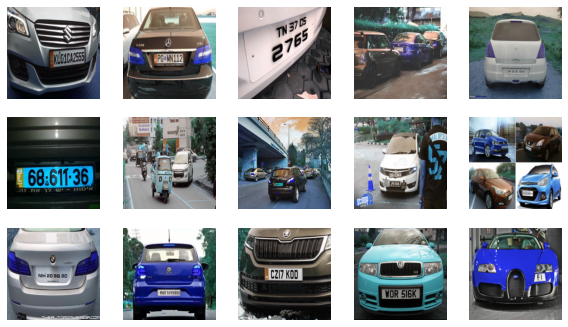

In [ ]:
plt.figure(figsize=(10,20))
for i in range(0,15) :
    plt.subplot(10,5,i+1)
    plt.axis('off')
    plt.imshow(X[i])

In [ ]:
#Transforming in array
X=np.array(X)
y=np.array(y)

In [ ]:
#Renormalisation
X = X / 255
y = y / 255

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

In [ ]:
from keras.models import Sequential

from keras.layers import Dense, Flatten

from keras.applications.vgg16 import VGG16

In [ ]:
# Create the model
model = Sequential()
model.add(VGG16(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="sigmoid"))

model.layers[-6].trainable = False

model.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 6, 6, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 128)               2359424   
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 4)                 260       
                                                         

In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [ ]:
train = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32, verbose=1)

Epoch 1/50
13/13 [==============================] - 26s 681ms/step - loss: 0.0255 - accuracy: 0.4524 - val_loss: 0.0096 - val_accuracy: 0.7045
Epoch 2/50
13/13 [==============================] - 3s 227ms/step - loss: 0.0088 - accuracy: 0.7635 - val_loss: 0.0067 - val_accuracy: 0.7955
Epoch 3/50
13/13 [==============================] - 3s 227ms/step - loss: 0.0048 - accuracy: 0.8252 - val_loss: 0.0046 - val_accuracy: 0.8636
Epoch 4/50
13/13 [==============================] - 3s 229ms/step - loss: 0.0031 - accuracy: 0.8766 - val_loss: 0.0052 - val_accuracy: 0.9545
Epoch 5/50
13/13 [==============================] - 3s 227ms/step - loss: 0.0021 - accuracy: 0.8895 - val_loss: 0.0046 - val_accuracy: 0.8864
Epoch 6/50
13/13 [==============================] - 3s 227ms/step - loss: 0.0015 - accuracy: 0.8869 - val_loss: 0.0043 - val_accuracy: 0.8409
Epoch 7/50
13/13 [==============================] - 3s 228ms/step - loss: 0.0013 - accuracy: 0.9049 - val_loss: 0.0048 - val_accuracy: 0.7500
Epoch

In [ ]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Score : %.2f%%" % (scores[1]*100))

Score : 88.64%


In [ ]:
def plot_scores(train) :
    accuracy = train.history['accuracy']
    val_accuracy = train.history['val_accuracy']
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'b', label='Score apprentissage')
    plt.plot(epochs, val_accuracy, 'r', label='Score validation')
    plt.title('Scores')
    plt.legend()
    plt.show()

In [ ]:
 y_cnn = model.predict(X_test)

In [ ]:
y_cnn.shape

(44, 4)

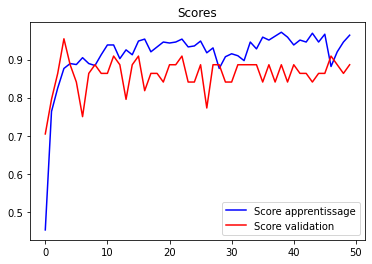

In [ ]:
plot_scores(train)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

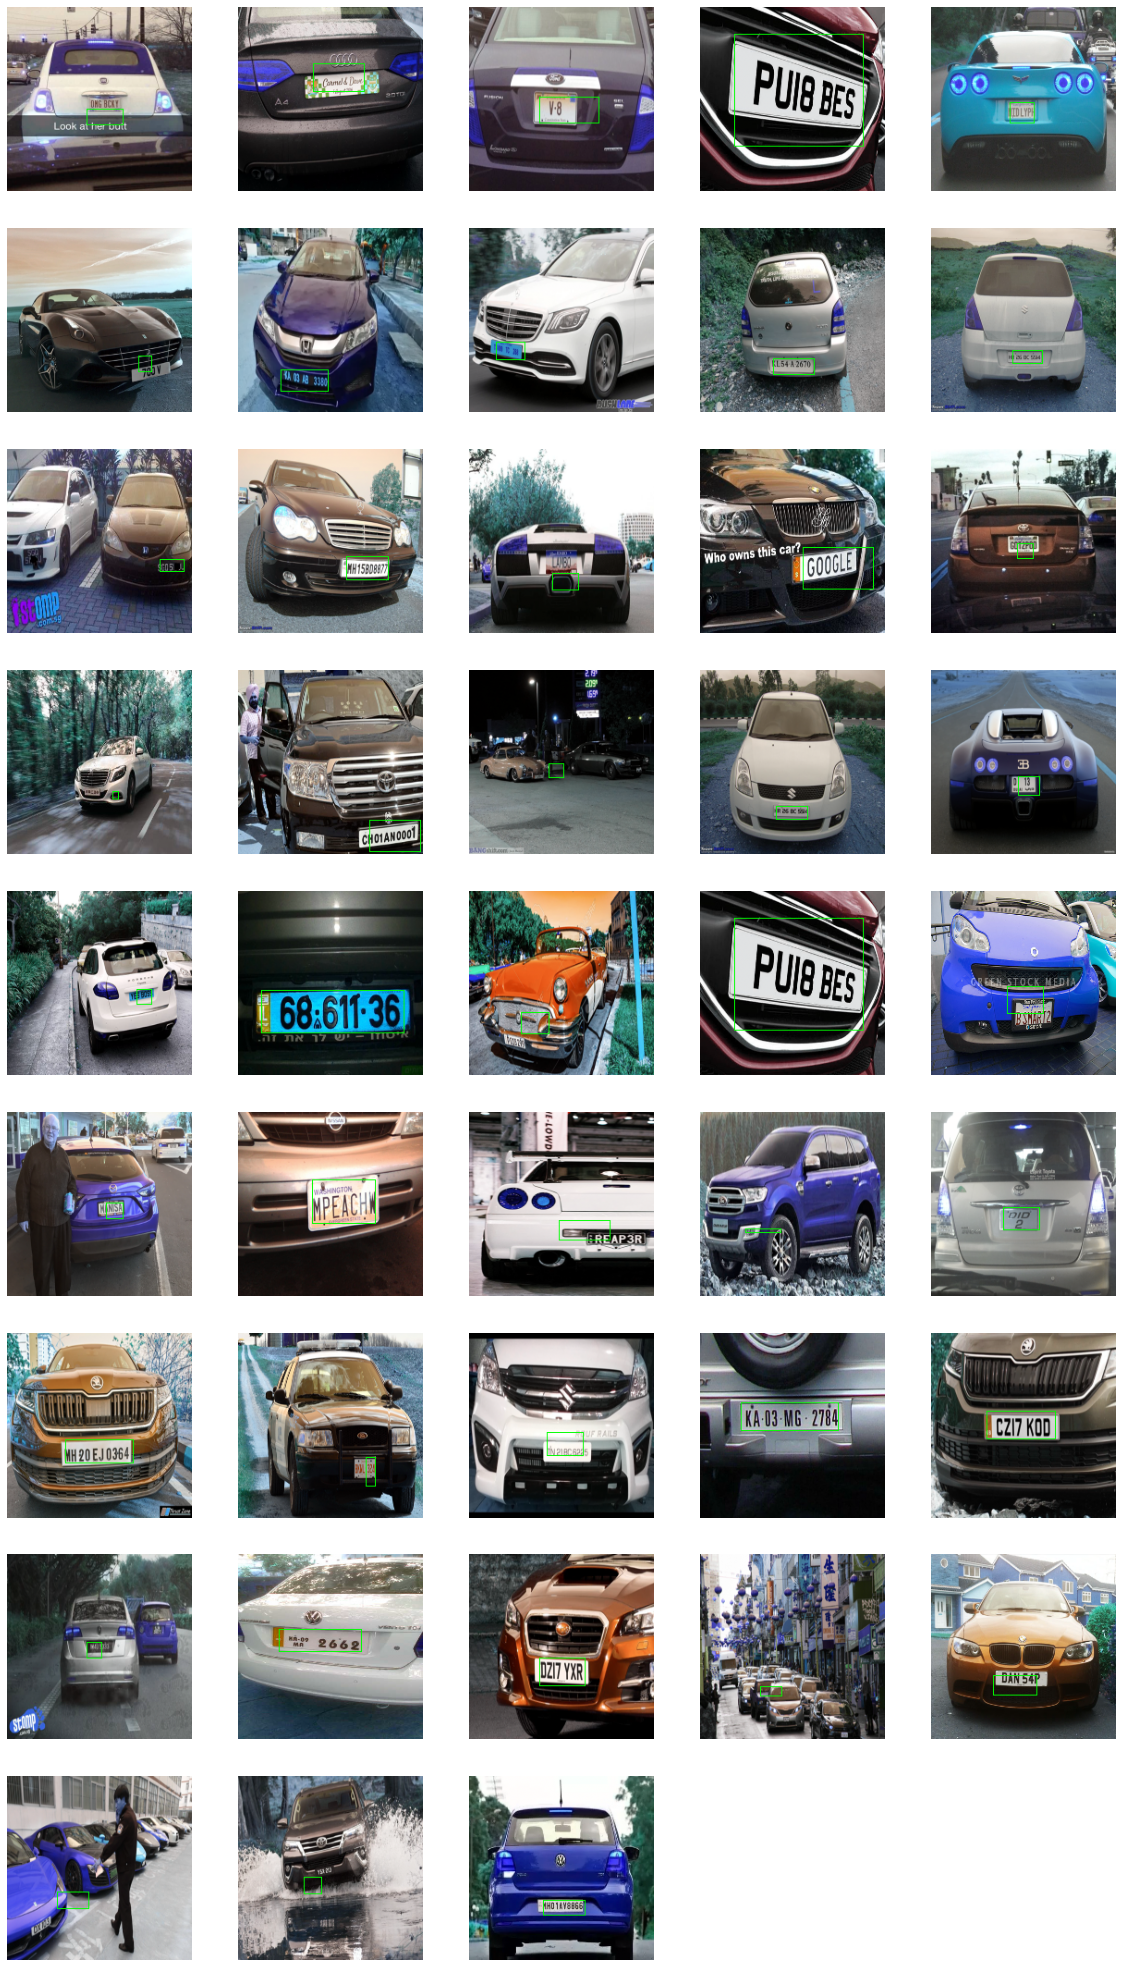

In [ ]:
plt.figure(figsize=(20,40))
for i in range(0,43) :
    plt.subplot(10,5,i+1)
    plt.axis('off')
    ny = y_cnn[i]*255
    image = cv2.rectangle(X_test[i],(int(ny[0]),int(ny[1])),(int(ny[2]),int(ny[3])),(0, 255, 0))
    plt.imshow(image)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


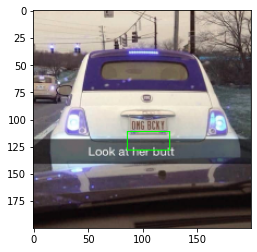

In [ ]:
plt.imshow(X_test[0])